The network predicts quality scores transformed from GMM loglikelihood for the between-subject case. The input to the network are the raw measurement data with 117 dimensions.

The fixed permutation “M1_Shuffled_Indices” in Data_shuffle is used to shuffle the data. 

CNN_GMM_Between_M1: predict quality scores and “Data_Load_GMM_Bet” is called to 
Load data.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.convolutional import Convolution1D
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
timesteps = 240, # timestep
nr = 90   # repetition number
n_dim = 117  # Dimension of data sequences
dropout_rate = 0.2   # Droput rate

In [3]:
import Data_Load_GMM_Bet   # Import the data
Correct_data, Correct_label, Incorrect_data, Incorrect_label = Data_Load_GMM_Bet.load_data()

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [4]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# First load the shuffled indices
f = open('../../Data_shuffle/M1_Shuffled_Indices.csv')
csv_f = csv.reader(f)
indcs = list(csv_f)

# Extract the training and validation indices
trainidx1 = np.squeeze(np.asarray(indcs[:int(nr*0.7)], dtype = np.float64))
trainidx1 = np.asarray(trainidx1, dtype = np.int32)   # convert input to an array
valididx1 = np.squeeze(np.asarray(indcs[int(nr*0.7):nr], dtype = np.float64))
valididx1 = np.asarray(valididx1, dtype = np.int32)
trainidx2 = np.squeeze(np.asarray(indcs[nr:nr+int(nr*0.7)], dtype = np.float64))
trainidx2 = np.asarray(trainidx2, dtype = np.int32)
valididx2 = np.squeeze(np.asarray(indcs[nr+int(nr*0.7):], dtype = np.float64))
valididx2 = np.asarray(valididx2, dtype = np.int32)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')
# print(train_x[0].shape)

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


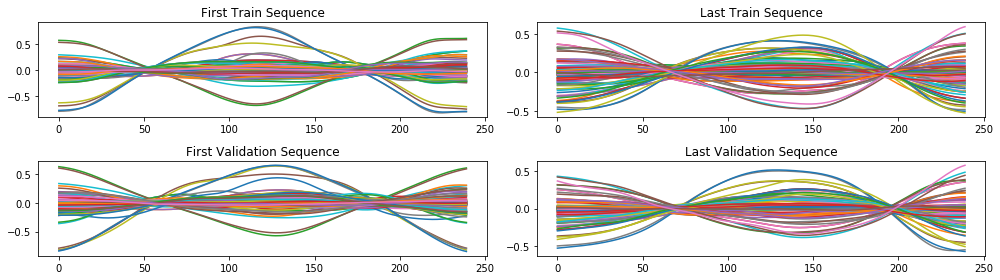

In [5]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [6]:
# Build CNN model ...
def Network():
    model = Sequential()
    model.add(Convolution1D(60, 5, padding ='same', strides = 2, input_shape = (240,117)))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(30, 3, padding ='same', strides = 2))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Convolution1D(10, 3, padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())

    model.add(Dense(200))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(100))
    model.add(LeakyReLU())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    model.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Request to stop before reaching the number of epochs if the Validaton Loss does not decrease for 100 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    t = now()
    history = model.fit(train_x, train_y, batch_size=5, epochs=5000, verbose=0, 
                     validation_data=(valid_x, valid_y),
                     callbacks = [early_stopping])
    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.plot(pred_train,'bo',train_y,'g*')
    plt.ylim([-0.1,1.1])
    plt.title('Labels for the training set')
    plt.subplot(1,2,2)
    plt.plot(pred_test,'bo',valid_y,'g*')
    plt.title('Labels for the testing set')
    plt.ylim([-0.1,1.1])
    plt.tight_layout()
    plt.show()
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    test_dev = abs(np.squeeze(pred_test)-valid_y)
    # Cumulative deviation
    mean_abs_dev = np.mean(test_dev)
    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('Mean absolute deviation:', mean_abs_dev)
    print('RMS deviation:', rms_dev)
    
    return mean_abs_dev, rms_dev


Training time: 0:00:35.981058


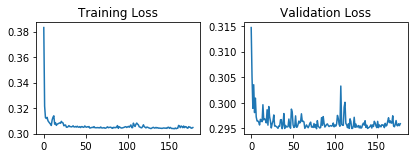

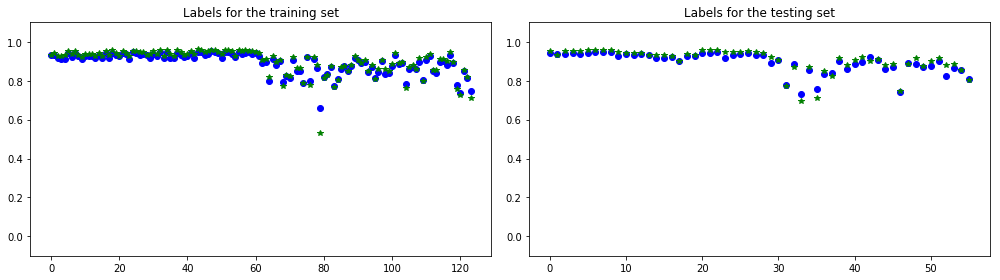

Mean absolute deviation: 0.014751197952542996
RMS deviation: 0.018266913525434997


In [7]:
# call the CNN model   
Mean_abs_dev, RMS_dev  = Network() 